In [1]:
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")

## tvAR(1) 

\begin{equation}
X_{t, T} + \alpha(\frac{t}{T}) X_{t-1, T} = \sigma(\frac{t}{T}) \epsilon_t
\end{equation}

### Define $\alpha (t)$

For all $t \in [0, 1], \; \alpha(t) \in (-1, 1)$

In [2]:
def alpha(t):
    return -0.8 * np.cos(1.5 - np.cos(4 * np.pi * t))

def sigma(t): 
    return np.cos(t * np.pi / 2 + np.exp(t)) ** 2

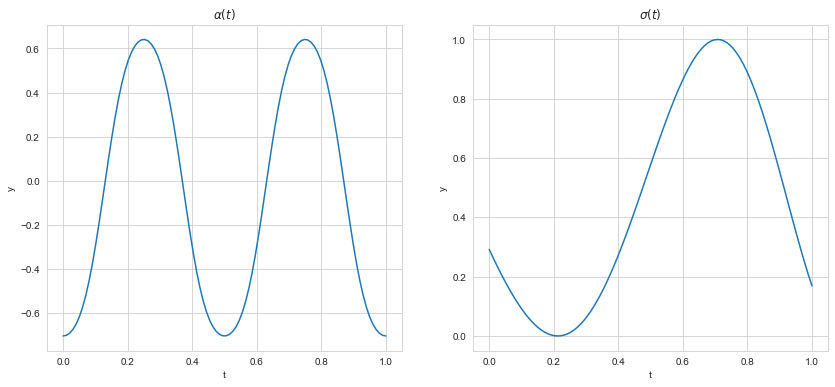

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

t = np.linspace(0, 1, 100)

sns.lineplot(x=t, y=alpha(t), ax=axs[0]);
sns.lineplot(x=t, y=sigma(t), ax=axs[1]);

axs[0].set_title(r"$\alpha(t)$")
axs[1].set_title(r"$\sigma(t)$")

for ax in axs.flat:
    ax.set_xlabel("t");
    ax.set_ylabel("y");

In [4]:
def simulate_tvAR_p(X_0, T, alpha_fun, sigma_fun, epsilon):
    X = np.empty(shape=(T,))
    X[0] = X_0
    
    for t in range(1, T):
        alpha_t = alpha_fun(t / T)
        sigma_t = sigma_fun(t / T)
        X[t] = X[t-1] * (-alpha_t) + sigma_t * epsilon[t]
        
    return X

### Application

In [5]:
T = 500
t_0 = 200 
u = t_0 / T

np.random.seed(1234)
epsilon = np.random.normal(0, 1, size=T) # noise used to generate X_t and X_tilde

# X_t
realisation = simulate_tvAR_p(0, T, alpha, sigma, epsilon)

# X_tilde_t
realisation_x_tilde = simulate_tvAR_p(0, T, lambda t: alpha(u), lambda t: sigma(u), epsilon)

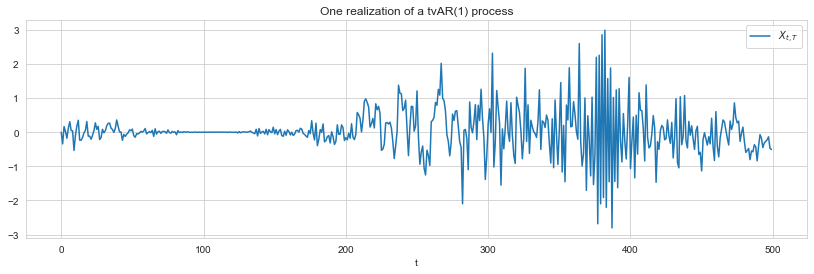

In [6]:
# only X_{t, T}
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(realisation, label=r"$X_{t,T}$");
ax.set_xlabel("t");
ax.set_title("One realisation of a tvAR(1) process");
ax.legend();

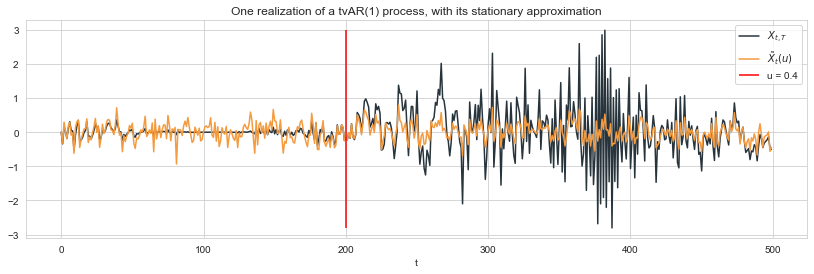

In [7]:
# X_{t, T} and X_tilde
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realisation, label=r"$X_{t,T}$", color="#28343c");
ax.plot(realisation_x_tilde, label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_0, ymin=realisation.min(), ymax=realisation.max(), color='red', label=f"u = {u}")

ax.set_xlabel("t");
ax.set_title("One realisation of a tvAR(1) process, with its stationary approximation");
ax.legend();

# plt.savefig("tvAR-1-example-full.pdf", bbox_inches="tight")

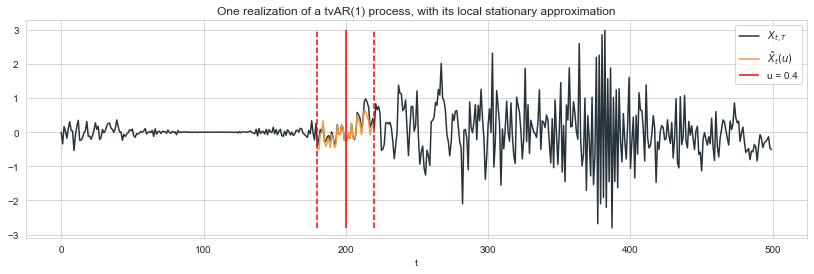

In [8]:
x_min = t_0 - 20
x_max = t_0 + 20

# figure
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realisation, label=r"$X_{t,T}$", color="#28343c");
ax.plot(range(x_min, x_max), realisation_x_tilde[x_min:x_max], label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_0, ymin=realisation.min(), ymax=realisation.max(), color='red', label=f"u = {u}")
ax.vlines(x_min, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')
ax.vlines(x_max, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')

ax.set_xlabel("t");
ax.set_title("One realisation of a tvAR(1) process, with its local stationary approximation");
ax.legend();

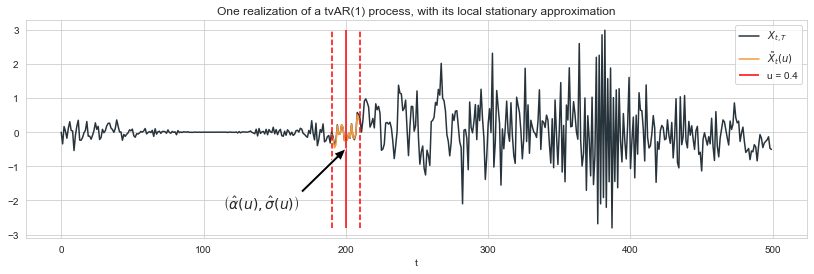

In [57]:
x_min = t_0 - 10
x_max = t_0 + 10

# figure
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realisation, label=r"$X_{t,T}$", color="#28343c");
ax.plot(range(x_min, x_max), realisation_x_tilde[x_min:x_max], label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_0, ymin=realisation.min(), ymax=realisation.max(), color='red', label=f"u = {u}")
ax.vlines(x_min, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')
ax.vlines(x_max, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')

ax.set_xlabel("t");
ax.set_title("One realisation of a tvAR(1) process, with its local stationary approximation");
ax.legend();

ax.annotate(r"$\left(\hat{\alpha}(u), \hat{\sigma}(u)\right)$", xy=(0.41, 0.41), xytext=(0.35, 0.2), xycoords='axes fraction', textcoords='axes fraction', arrowprops=dict(width=3, headwidth=10, facecolor='black'), fontsize=14, horizontalalignment='right', verticalalignment='top');

# plt.savefig("tvAR-1-example.pdf", bbox_inches="tight")

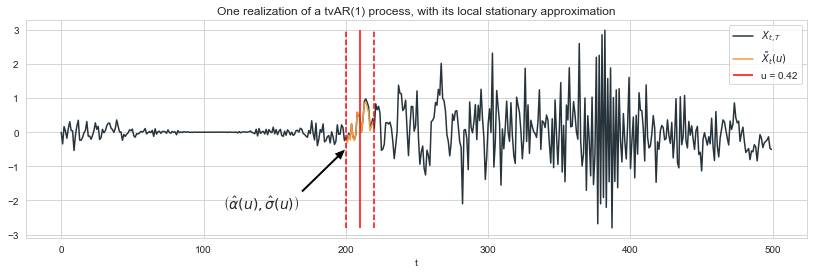

In [55]:
t_00 = 210
uu = t_00 / T
realisation_x_tilde_uu = simulate_tvAR_p(0, T, lambda t: alpha(uu), lambda t: sigma(uu), epsilon)

x_min = t_00 - 10
x_max = t_00 + 10

# figure
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(realisation, label=r"$X_{t,T}$", color="#28343c");
ax.plot(range(x_min, x_max), realisation_x_tilde_uu[x_min:x_max], label=r"$\tilde{X}_t(u)$", color="#F49A3F")
ax.vlines(t_00, ymin=realisation.min(), ymax=realisation.max(), color='red', label=f"u = {uu}")
ax.vlines(x_min, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')
ax.vlines(x_max, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')

ax.set_xlabel("t");
ax.set_title("One realisation of a tvAR(1) process, with its local stationary approximation");
ax.legend();

ax.annotate(r"$\left(\hat{\alpha}(u), \hat{\sigma}(u)\right)$", xy=(0.41, 0.41), xytext=(0.35, 0.2), xycoords='axes fraction', textcoords='axes fraction', arrowprops=dict(width=3, headwidth=10, facecolor='black'), fontsize=14, horizontalalignment='right', verticalalignment='top');

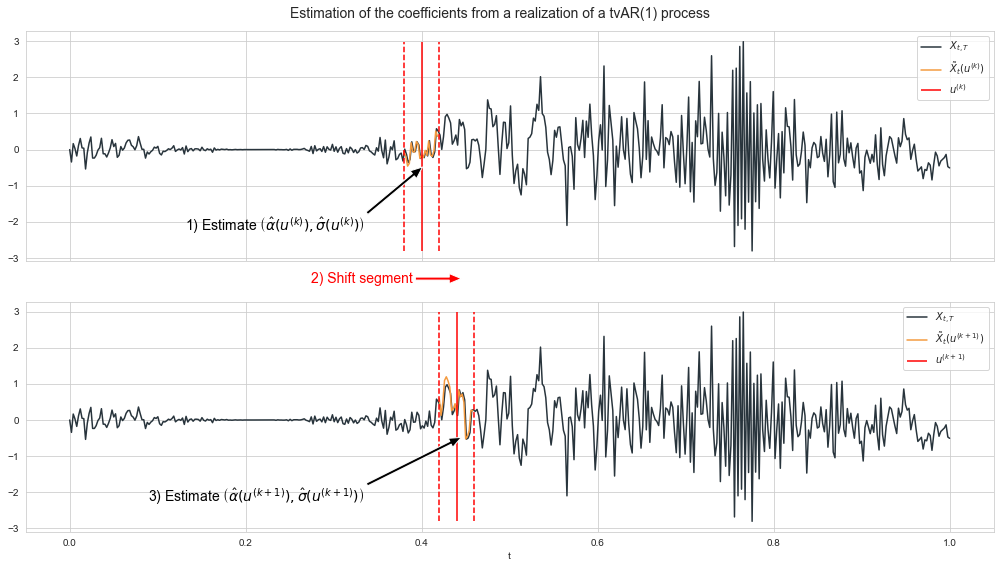

In [111]:
t_00 = 220
uu = t_00 / T
realisation_x_tilde_uu = simulate_tvAR_p(0, T, lambda t: alpha(uu), lambda t: sigma(uu), epsilon)
x_min_2 = t_00 - 10
x_max_2 = t_00 + 10

# figure
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axs[0].plot(np.linspace(0, 1, len(realisation)), realisation, label=r"$X_{t,T}$", color="#28343c");
axs[0].plot(list(map(lambda x: x/T, range(x_min, x_max))), realisation_x_tilde[x_min:x_max], label=r"$\tilde{X}_t(u^{(k)})$", color="#F49A3F")
axs[0].vlines(t_0/T, ymin=realisation.min(), ymax=realisation.max(), color='red', label=r"$u^{(k)}$")
axs[0].vlines(x_min/T, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')
axs[0].vlines(x_max/T, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')
axs[0].legend();

axs[0].annotate("1) Estimate " + r"$\left(\hat{\alpha}(u^{(k)}), \hat{\sigma}(u^{(k)})\right)$", xy=(0.41, 0.41), xytext=(0.35, 0.2), xycoords='axes fraction', textcoords='axes fraction', arrowprops=dict(width=3, headwidth=10, facecolor='black'), color='black', fontsize=14, horizontalalignment='right', verticalalignment='top');


axs[1].plot(np.linspace(0, 1, len(realisation)), realisation, label=r"$X_{t,T}$", color="#28343c");
axs[1].plot(list(map(lambda x: x/ T, range(x_min_2, x_max_2))), realisation_x_tilde_uu[x_min_2:x_max_2], label=r"$\tilde{X}_t(u^{(k+1)})$", color="#F49A3F")
axs[1].vlines(t_00/T, ymin=realisation.min(), ymax=realisation.max(), color='red', label=r"$u^{(k+1)}$")
axs[1].vlines(x_min_2/T, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')
axs[1].vlines(x_max_2/T, ymin=realisation.min(), ymax=realisation.max(), color='red', linestyle='--')

axs[1].set_xlabel("t");
axs[1].legend();

axs[1].annotate("3) Estimate " + r"$\left(\hat{\alpha}(u^{(k+1)}), \hat{\sigma}(u^{(k+1)})\right)$", xy=(0.45, 0.41), xytext=(0.35, 0.2), xycoords='axes fraction', textcoords='axes fraction', arrowprops=dict(width=3, headwidth=10, facecolor='black'), color='black', fontsize=14, horizontalalignment='right', verticalalignment='top');

fig.suptitle("Estimation of the coefficients from a realisation of a tvAR(1) process", fontsize=14)
plt.annotate('2) Shift segment', xy=(0.45, 1.1), xytext=(0.40, 1.1), xycoords='axes fraction', textcoords='axes fraction', arrowprops=dict(width=3, headwidth=10, facecolor='red'), fontsize=14, color='red', horizontalalignment='right', verticalalignment='center');
plt.tight_layout()


# plt.savefig("coefficients-estimation-tvAR-1.pdf", bbox_inches="tight")

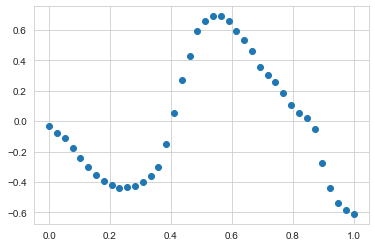

In [120]:
import numpy as np
import scipy.linalg

class Kernel:

    def __init__(self, kernel_str) -> None:
        assert kernel_str in ["gaussian", "uniform", "epanechnikov"]
        self.kernel_str = kernel_str

    def __call__(self, x):
        if self.kernel_str == "gaussian":
            return (1 / np.sqrt(2 * np.pi)) * np.exp(-(x ** 2) / 2)
        elif self.kernel_str == "uniform":
            return 1 / 2 * (np.abs(x) <= 1) 
        elif self.kernel_str == "epanechnikov":
            return (1 - x ** 2) * 3 / 4 * (np.abs(x) <= 1)
    

def estimate_local_autocovariance(X, t_0, k, kernel, bandwidth):
    """
    Returns an estimate of the autocovariance of X at t_0 and lag k.
    Can be multidimensional if X represents several realisations.

    --- parameters
    - X: array representing one (or several) realisations of the process
    - t_0: point where estimate the covariance
    - k: lag
    - kernel: localizing kernel used in the estimation
    - bandwidth: bandwidth of the kernel
    """
    T = X.shape[0]
    return np.sum(
        (
            kernel((t_0 - (np.arange(T-k) + k / 2)) / (bandwidth * T)).repeat(X.shape[1]).reshape(X[k:, :].shape) 
            * X[:T-k, :] 
            * X[k:, :]
        ), axis=0) / (bandwidth * T)


def estimate_yw_coef(c_list):
    """
    Estimates the Yule-Walker estimates for an AR(p) model. Supports multi-dimensional time series (for Monte Carlo simulations).

    --- parameters
    - c_list: autocovariance sequence ((c_0, ..., c_p), ...)
    """
    yw_coeff = np.empty(shape=c_list.shape) # (p+1, n_realisations)

    for i in range(c_list.shape[1]):
        gamma = c_list[1:, i]
        Gamma = scipy.linalg.toeplitz(c=c_list[:-1, i], r=c_list[:-1, i])
        alpha_hat = -np.dot(scipy.linalg.inv(Gamma), gamma) 
        sigma_hat = np.sqrt(c_list[0, i] + np.dot(gamma, alpha_hat))
        yw_coeff[:, i] = np.concatenate((alpha_hat, [sigma_hat]), axis=0)
    
    return yw_coeff


def estimate_parameters_tvAR_p(time_series: np.ndarray, p: int, u_list: np.ndarray, kernel: Kernel, bandwidth: float):
    """
    Returns the Yule-Walker estimates of a tvAR(p) model. Supports multi-dimensional time series for Monte-Carlo simulations.

    --- parameters
    - time_series: time series with shape (T, n_realisations)
    - p: order of the tvAR(p) model
    - u_list: list of points between 0 and 1 where to evaluate the parameters.
    - kernel: kernel used for the autocovariance approximation
    - bandwidth: bandwidth used in the non-parametric estimation
    """
    T = time_series.shape[0]
    time_series = time_series.reshape(T, -1) # make sure time series shape is (T, n_realisations)
    estimates = np.empty(shape=(u_list.shape[0], p + 1, time_series.shape[1])) # (alpha_1, ..., alpha_p, sigma) for each time series at each point u

    for i, u_0 in enumerate(u_list):
        # define the window
        t_0 = int(u_0 * T)
        start = max(0, int(t_0 - bandwidth * T / 2))
        end = min(T-1, int(t_0 + bandwidth * T / 2))
        time_series_window = time_series[start:(end+1), :]

        # estimate the covariance and Yule-Walker estimates
        c_list = np.array([estimate_local_autocovariance(time_series_window, t_0 - start, k, kernel, bandwidth) for k in range(p+1)]).reshape((p+1, -1))
        estimates[i, :, :] = estimate_yw_coef(c_list)

    return estimates


def forecast_future_values_tvAR_p(p, alpha_forecasts, time_series):
    # returns (n_forecasts,)
    n_forecasts = alpha_forecasts.shape[0]
    forecasts = np.empty((n_forecasts,))
    p_last_values = time_series[-p:]
    for i in range(n_forecasts):
        x_star = -np.sum(p_last_values * np.flip(alpha_forecasts[i, :]), axis=0) # alpha needs to be flipped to have (X_{t-p} * alpha_p, ...) and not (X_{t-p} * alpha_1, ...)
        forecasts[i] = x_star
        p_last_values = np.concatenate([p_last_values[1:], [x_star]]) 
    return forecasts


u_list = np.linspace(0, 1, 100, endpoint=False)
bandwidth = T ** (-1/5)

yw_estimates = estimate_parameters_tvAR_p(realisation, 1, u_list, Kernel("epanechnikov"), bandwidth)
alpha_hat = yw_estimates[:, 0, :]
sigma_hat = yw_estimates[:, 1, :]

fig, ax = plt.subplots()
ax.scatter(np.linspace(0, 1, len(alpha_hat.squeeze()[:int(100*u)])), alpha_hat.squeeze()[:int(100*u)])

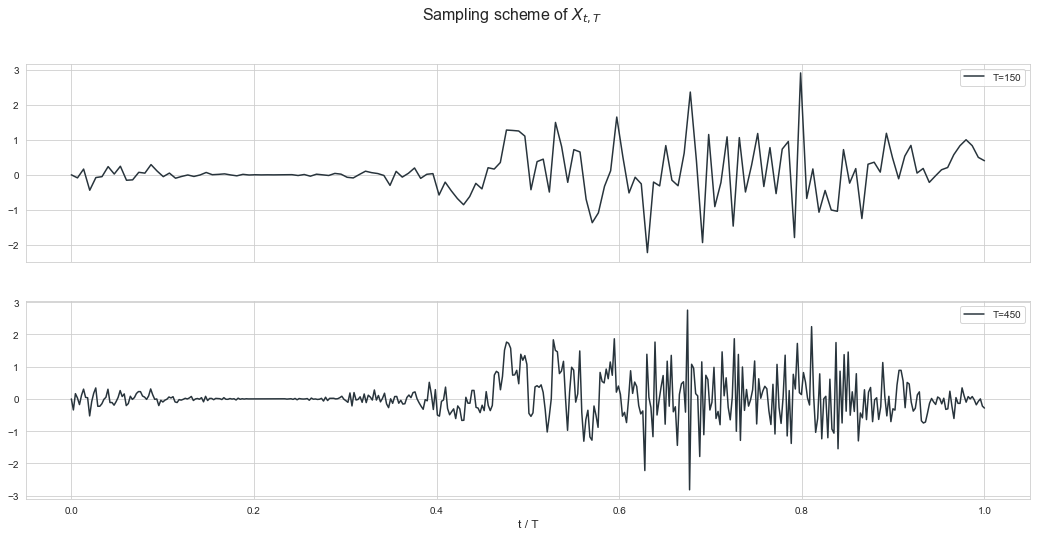

In [26]:
T_1 = 150
T_2 = 450

np.random.seed(1234)
epsilon_2 = np.random.normal(0, 1, size=T_2) 
epsilon_1 = epsilon_2[::int(T_2 / T_1)]

# X_t
realisation_1 = simulate_tvAR_p(0, T_1, alpha, sigma, epsilon_1)
realisation_2 = simulate_tvAR_p(0, T_2, alpha, sigma, epsilon_2)

# figure
fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

axs[0].plot(np.linspace(0, 1, len(realisation_1)), realisation_1, label=f"T={T_1}", color="#28343c");
axs[1].plot(np.linspace(0, 1, len(realisation_2)), realisation_2, label=f"T={T_2}", color="#28343c");

fig.suptitle("Sampling scheme of " + r"$X_{t,T}$", fontsize=16);
axs[1].set_xlabel("t / T", fontsize=12)
axs[0].legend();
axs[1].legend();

# plt.savefig("sampling-scheme.pdf", bbox_inches="tight")

## Test with pairs trading
###  COIN / BTC

In [10]:
# download data
data = yf.download("COIN BTC", start="2015-01-01")
data = data['Close']
data = data.dropna()

[*********************100%***********************]  2 of 2 completed


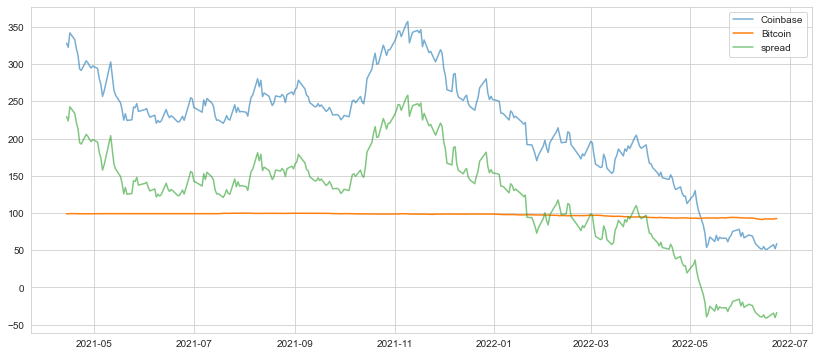

In [11]:
spread_series = data['COIN'] - data['BTC']

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(data['COIN'], alpha=0.6, label="Coinbase")
ax.plot(data['BTC'], label="Bitcoin")
ax.plot(spread_series, alpha=0.6, label="spread")

ax.legend();

[*********************100%***********************]  2 of 2 completed


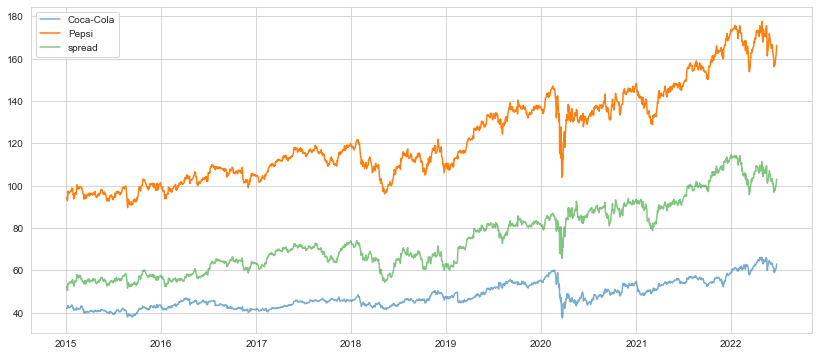

In [12]:
# download data
data = yf.download("KO PEP", start="2015-01-01")
data = data['Close']
data = data.dropna()

# plot
spread_series = data['PEP'] - data['KO']

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(data['KO'], alpha=0.6, label="Coca-Cola")
ax.plot(data['PEP'], label="Pepsi")
ax.plot(spread_series, alpha=0.6, label="spread")

ax.legend();

## S&P 500

In [13]:
sp500_df = yf.download("^GSPC", start="1999-01-01")
sp500_df = sp500_df['Close']

[*********************100%***********************]  1 of 1 completed


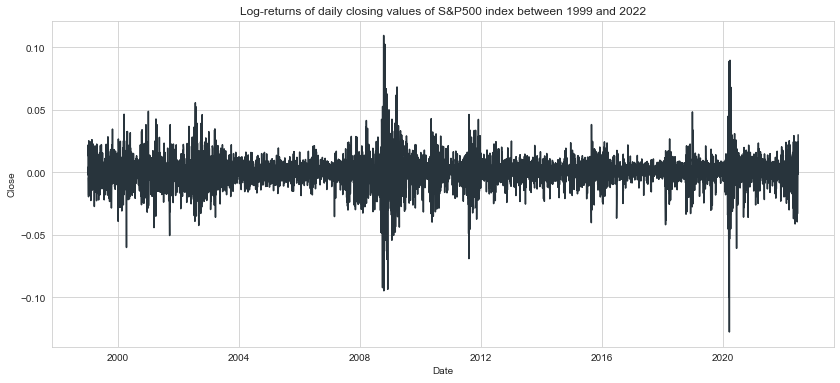

In [14]:
# daily log returns
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=np.log(1 + sp500_df.pct_change()), color="#28343c", ax=ax);
ax.set_title("Log-returns of daily closing values of S&P500 index between 1999 and 2022");

# plt.savefig("sp500-log-returns.pdf", bbox_inches="tight")

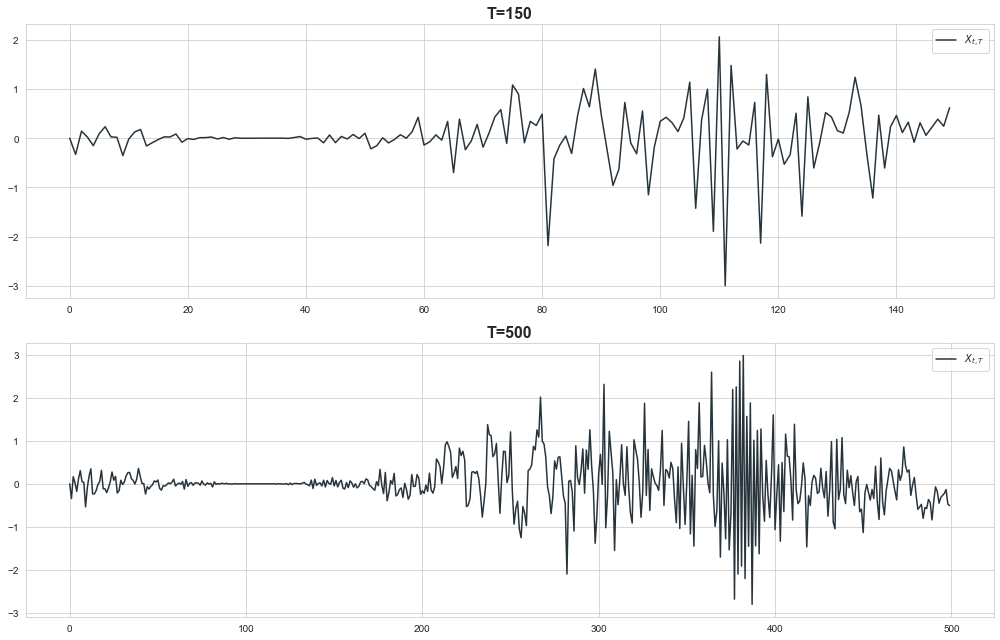

In [39]:
T_list = [150, 500]

fig, axs = plt.subplots(2, 1, figsize=(14, 9))

for i, T in enumerate(T_list):
    np.random.seed(1234)
    epsilon = np.random.normal(0, 1, size=T) # noise used to generate X_t and X_tilde

    # X_t
    realisation = simulate_tvAR_p(0, T, alpha, sigma, epsilon)

    # figure
    axs[i].plot(realisation, label=r"$X_{t,T}$", color="#28343c");
    axs[i].set_title(f"{T=}", fontweight='bold', fontsize=16);
    axs[i].legend();

fig.tight_layout()
# plt.savefig("process-sampling.pdf")
